# **N10. RCNN MODELS**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import libraries.utilities as ut
import os
from astropy.io import fits

import math
import os
import numpy as np
from PIL import Image
import cv2
#!pip install numpy==1.26.4
import gc
gc.collect()

0

**Load objects**

In [2]:
# Load objects from file.
objects = pd.read_parquet("objects_all.parquet")

# Count number of unique FITS files.
number_files = objects["FILENAME"].unique()

# Check number.
print(f"Number of files: {len(number_files)}")

Number of files: 1314


**Load stars**

In [3]:
#stars = pd.read_pickle("resources/database/stars_db/stars.pkl")
#stars = stars.drop(["REGION"], axis = 1)
#stars.to_parquet("resources/database/stars_db/stars.parquet")

# Load stars.
stars = pd.read_parquet("resources/database/stars_db/stars.parquet")
filenames = list(objects["FILENAME"].unique())

# Extract stars.
stars= stars[stars["FILENAME"].isin(filenames)]

# Combine all.
objects_combined = pd.concat([stars, objects], axis = 0).reset_index(drop= True)

## 1. Download fits files

Given the set of detected objects (filtered), download all the corresponding FITS images.

In [1]:
def download_fits_samples(objects_files, folder_out = os.path.join("results", "fits_files")):
    """
    Download a set of FITS L0 samples and extract the image.
    """

    filenames = objects_files["FILENAME"].unique()
    errors = []

    for i in range(len(filenames)):
        filename_test = filenames[i]
        url = objects_files[objects_files["FILENAME"] == filenames[i]]["url"].iloc[0]
        try:
            ut.download_fits(url, filename_test, folder_out)
            print(f"Download {i} done!")
        
        except:
            errors.append([filename_test, url])

    return errors
    
# Download images.
#download_fits_samples(objects)


NameError: name 'os' is not defined

Display an example of the detected objects and the corresponding image.

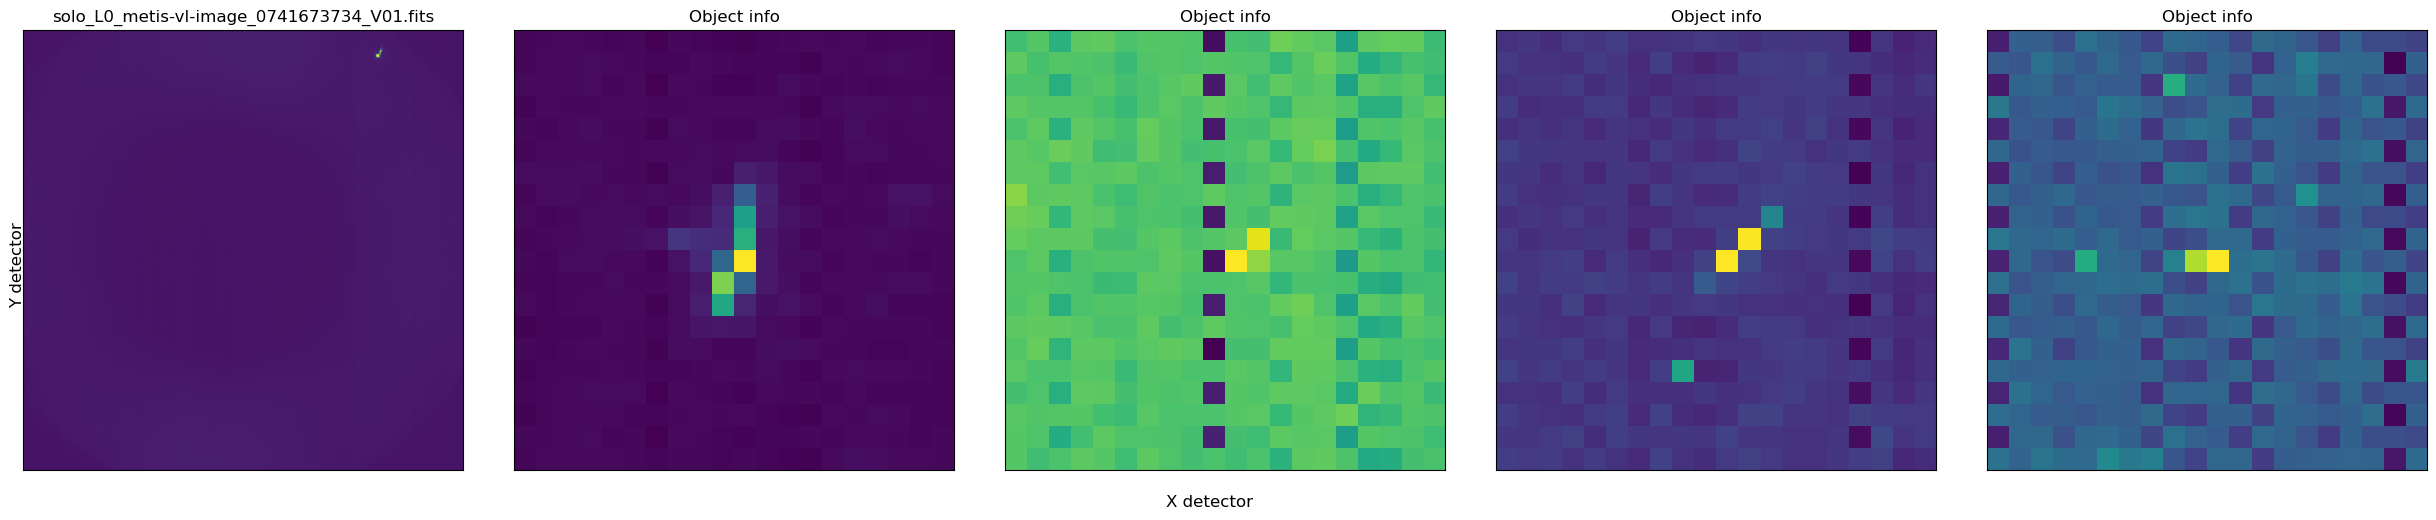

In [23]:
# Check size of files.
FITS_DIR = "results/fits_files"
size_dir = os.listdir(FITS_DIR)

# Example file.
n_file = np.random.randint(len(size_dir))
example_fits = size_dir[n_file]

# Extract coordiantes.
coords = objects_combined[objects_combined["FILENAME"] == example_fits][["X_COORD", "Y_COORD", "INFO"]]
size_coords = len(coords)

# Create figure.
fig, axis = plt.subplots(1, 1 + size_coords , figsize = (5 + size_coords*5, 5))
fig.supxlabel("X detector"), fig.supylabel("Y detector")
img = fits.open(os.path.join(FITS_DIR, example_fits))[0].data
lim = 10

for i in range(size_coords + 1):
    axis[i].set_xticks([]), axis[i].set_yticks([])
    if i == 0:  
        axis[i].set_title(example_fits)
        axis[i].imshow(img)
    else:
        x = int(coords.iloc[i-1]["X_COORD"])
        y = int(coords.iloc[i-1]["Y_COORD"])
        info = coords.iloc[i-1]["INFO"]
        axis[i].imshow(img[y-lim:y+lim, x-lim:x+lim])
        axis[i].set_title(f"Object {info}")

fig.tight_layout()

###

## 2. Fits processing.

Create the dataset for feeding YOLO model.

In [24]:
def extract_pos(dataframe, filename):
    """
    Extract coordinates of retrieved objects in each of the fits images.
    """

    refined_df = dataframe[dataframe["FILENAME"] == filename]
    coords = []

    for i in range(len(refined_df)):
        coords.append([int(refined_df.iloc[i]["X_COORD"]),int(refined_df.iloc[i]["Y_COORD"])])

    return coords


def stretch_image(data, lo=1, hi=99.5, stretch='asinh', alpha=10):
    """
    Clean image and convert to pixel value range.
    """

    vmin, vmax = np.percentile(data, [lo, hi])
    data = np.clip(data, vmin, vmax)
    data = (data - vmin) / (vmax - vmin + 1e-6)
    
    # Stretch
    if stretch == 'log':
        data = np.log1p(1000*data)
        data /= data.max()
    elif stretch == 'asinh':
        data = np.arcsinh(alpha*data)
        data /= data.max()

    # Convert [0,1] → [0,255] and uint8
    img_8bit = (data * 255).astype(np.uint8)

    return img_8bit

def tile_image_4x4(image_array, overlap=0.05, prefix="tile"):
    """
    Split the full image into several smaller regions where YOLO could predict better object detection.
    """

    H = 2048
    W = 2048

    N = 5
    f = float(overlap)


    # Solve for tile_size so that N tiles with overlap f cover exactly W:
    # coverage = tile_size * (N - (N-1)*f) = W
    tile_size = W / (N - (N - 1) * f)
    tile_size = int(round(tile_size))  # integer pixels

    # Stride between tiles (how much we move): stride = tile_size * (1 - f)
    stride = int(round(tile_size * (1.0 - f)))

    # Recompute last tile start to ensure exact coverage (avoid off-by-one)
    last_start = W - tile_size
    # Build start indices along one axis
    starts = [min(i * stride, last_start) for i in range(N)]

    tiles_info = []
    tiles = []

    for r, y0 in enumerate(starts):
        for c, x0 in enumerate(starts):
            y1, x1 = y0 + tile_size, x0 + tile_size
            tile = image_array[y0:y1, x0:x1]  # HxW or HxWxC
            tiles.append(tile)


            tiles_info.append({
                "row": r, "col": c,
                "x0": int(x0), "y0": int(y0),
                "w": int(tile.shape[1]), "h": int(tile.shape[0])
            })

    return tiles_info, tiles


def check_objects(tiles, info, objects, out_path, filename, bbox = 9):
    """
    Check if there exists objects in the new sliced images and save labels into a txt and picture into .png.
    """
    
    for i in range(len(info)):
        lines = []

        for k in range(len(objects)):
            x = objects[k][0]
            y = objects[k][1]

            # Create line for saving object position in each tile.
            tile_size = info[i]["w"]
            x_tile = info[i]["x0"]
            y_tile = info[i]["y0"]

            # Check if a given tile has an boject inside.
            if x_tile < x and x_tile + tile_size > x:
                if info[i]["y0"] < y and info[i]["y0"] + tile_size >  y:

                    # Compute new coordinates for this image.
                    y_new = y-y_tile
                    x_new = x-x_tile

                    # Save in YOLO format.
                    x_center_norm = x_new / tile_size
                    y_center_norm = y_new / tile_size
                    width_norm    = bbox / tile_size
                    height_norm   = bbox / tile_size
                    
                    # Store information in lines.
                    lines.append(f"{0} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}")
        
        if len(lines)>0:
            with open(os.path.join(out_path, "labels", filename[:-5] + f"_{i}.txt"), "w") as f:
                f.write("\n".join(lines))

            
        else:
            with open(os.path.join(out_path, "labels", filename[:-5] + f"_{i}.txt"), "w") as f:
                f.write("\n".join(lines))

        # Make 3-channel for YOLO pretrained models
        img_rgb = cv2.merge([tiles[i], tiles[i], tiles[i]])

        # Save as PNG
        cv2.imwrite(os.path.join(out_path, "images", filename[:-5] + f"_{i}.png"), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))


Combine all functions defined and create the dataset for feeding into YOLO.

In [25]:

def create_dataset(path_to_images, objects_coordinates):
    """
    Extract FITS files from a folder and perform the following actions:
    - Normalize image and prepare for YOLO training.
    - Split image into different sub regions.
    - Check if there exists an object inside each region.
    - Save images and .txt files for each image.
    """

    # Output path.
    OUTPATH = "yolo_dataset"
    
    # Extract image in folder.
    fits_files = os.listdir(path_to_images)

    # Iterate over every image.
    for fit_img in fits_files:

        # Extract objects in each image.
        coordinates = extract_pos(objects_coordinates, fit_img)

        # Load image.
        img = fits.open(os.path.join(path_to_images, fit_img))[0].data

        # Prepare image for YOLO.
        img_proc = stretch_image(img)

        # Crop image. 
        sub_images_info, sub_images = tile_image_4x4(img_proc, 0.05)

        # Save image and labels.
        check_objects(sub_images, sub_images_info, coordinates, OUTPATH, fit_img, bbox = 9)

# Create dataset.
create_dataset("results/fits_files", objects_combined)



### 2.1 Dataset verification

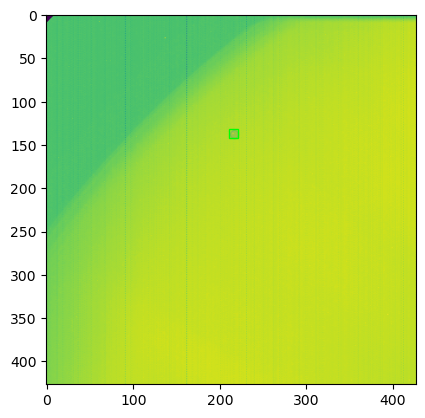

In [52]:
path_labels = "yolo_dataset/labels"
path_images = "yolo_dataset/images"


LABELS = os.listdir(path_labels)
files_with_objects = []
for i in range(len(LABELS)):

    with open(os.path.join(path_labels,LABELS[i]), "r") as f:
        content = f.read().strip()

    if content:
        files_with_objects.append(LABELS[i])

with open(os.path.join(path_labels, files_with_objects[0]), "r") as f:
    content = f.read().strip().split()
    w = float(content[3])
    x = float(content[1])
    y = float(content[2])
img = os.path.join(path_images, files_with_objects[0][:-3] +"png")
img_gray = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
img_gray_shp = img_gray.shape[0]
plt.imshow(img_gray)
plt.scatter(x*img_gray_shp, y*img_gray_shp, alpha= 0.2)


w_norm = w
h_norm = w
w_px = w_norm * img_gray_shp
h_px = h_norm * img_gray_shp
x_center_px = x*img_gray_shp
y_center_px = y*img_gray_shp

# Box corners
xmin = x_center_px - w_px/2
ymin = y_center_px - h_px/2
xmax = x_center_px + w_px/2
ymax = y_center_px + h_px/2
plt.gca().add_patch(plt.Rectangle((xmin, ymin), w_px, h_px,
                                edgecolor='lime', facecolor='none', linewidth=1))


### 2.3 Dataset preparation

In [55]:
LABELS = os.listdir(path_labels)
files_with_objects = []
for i in range(len(LABELS)):

    with open(os.path.join(path_labels,LABELS[i]), "r") as f:
        content = f.read().strip()

    if content:
        files_with_objects.append(LABELS[i])

In [28]:
import os, random, shutil, pathlib

random.seed(42)

images_dir = pathlib.Path("yolo_dataset/images")
labels_dir = pathlib.Path("yolo_dataset/labels")

NEG_PER_POS = 2          # choose 1–2 for training; 4 is okay for val only
TRAIN_FRACTION = 0.8
OUT = pathlib.Path("YOLO")
USE_SYMLINKS = False     # set True on Linux/macOS to save space

def has_objects(label_path: pathlib.Path) -> bool:
    if not label_path.exists():
        return False  # treat missing label as negative (or create empty file upstream)
    try:
        txt = label_path.read_text().strip()
    except Exception:
        return False
    return len(txt) > 0

positives, negatives = [], []

for img_path in images_dir.iterdir():
    if not img_path.is_file():
        continue
    if img_path.suffix.lower() not in {".png", ".jpg", ".jpeg"}:
        continue
    lab_path = labels_dir / (img_path.stem + ".txt")
    if has_objects(lab_path):
        positives.append(img_path)
    else:
        negatives.append(img_path)

print(f"Found {len(positives)} positives, {len(negatives)} negatives")

# keep all positives; sample negatives to desired ratio
k_neg = min(len(negatives), NEG_PER_POS * len(positives))
neg_sample = random.sample(negatives, k_neg)

# stratified split: do 80/20 inside each group
def split_list(lst, frac):
    n = int(round(frac * len(lst)))
    return lst[:n], lst[n:]

random.shuffle(positives)
random.shuffle(neg_sample)

pos_train, pos_val = split_list(positives, TRAIN_FRACTION)
neg_train, neg_val = split_list(neg_sample, TRAIN_FRACTION)

train_imgs = pos_train + neg_train
val_imgs   = pos_val   + neg_val
random.shuffle(train_imgs)
random.shuffle(val_imgs)

def place(split, img_paths):
    img_out = OUT / "images" / split
    lab_out = OUT / "labels" / split
    img_out.mkdir(parents=True, exist_ok=True)
    lab_out.mkdir(parents=True, exist_ok=True)

    for img in img_paths:
        lab = labels_dir / (img.stem + ".txt")
        dst_img = img_out / img.name
        dst_lab = lab_out / lab.name

        if USE_SYMLINKS:
            # remove if exists to avoid error
            for src, dst in [(img, dst_img), (lab, dst_lab)]:
                if dst.exists() or dst.is_symlink():
                    dst.unlink()
            os.symlink(os.path.abspath(img), dst_img)
            # ensure label file exists (empty for negatives)
            if not lab.exists():
                lab.write_text("")
            os.symlink(os.path.abspath(lab), dst_lab)
        else:
            shutil.copy2(img, dst_img)
            # ensure label file exists (empty for negatives)
            if not lab.exists():
                lab.write_text("")
            shutil.copy2(lab, dst_lab)

place("train", train_imgs)
place("val", val_imgs)

print(f"Train: {len(train_imgs)} (pos {len(pos_train)}, neg {len(neg_train)})")
print(f"Val:   {len(val_imgs)} (pos {len(pos_val)},   neg {len(neg_val)})")


Found 3749 positives, 29101 negatives
Train: 8997 (pos 2999, neg 5998)
Val:   2250 (pos 750,   neg 1500)


## 3. Training

In [2]:
import os, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from ultralytics import YOLO
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [2]:
import os, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from ultralytics import YOLO
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = YOLO("yolov8n-p2.yaml").load("yolov8n.pt")

model.train(
    data="yolo.yaml",
    device=0,
    imgsz=400,          # 512 is the sweet spot for 4 GB
    batch=40,            # or -1 for auto; start with 2 to be safe
    epochs=100,

    workers=0,          # steadier on low VRAM/RAM
    rect=True,
    cache=False,

    mosaic=0.0,         # lower peak memory + more stable
    translate=0.03, scale=0.10, shear=0.0, degrees=0.0,
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.08,

    optimizer="adamw",
    cos_lr=True,
    amp=True,           # mixed precision = big VRAM saver
    seed=42,
    plots=False,        # saves CPU/RAM/IO
)


Transferred 219/437 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.184 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.176 🚀 Python-3.10.16 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=40, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=yolo.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.08, imgsz=400, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-p2.yaml, momentum=0.937, mosaic=0.0, multi_scale=False,

train: Scanning /home/stefano98/University of Padua/thesis/METIS/YOLO/labels/train.cache... 8997 images, 5998 backgrounds, 0 corrupt: 100%|██████████| 8997/8997 [00:00<?, ?it/s]


WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4657.6±974.0 MB/s, size: 317.5 KB)


val: Scanning /home/stefano98/University of Padua/thesis/METIS/YOLO/labels/val.cache... 2250 images, 1500 backgrounds, 0 corrupt: 100%|██████████| 2250/2250 [00:00<?, ?it/s]

optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 70 weight(decay=0.0), 79 weight(decay=0.000625), 78 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to /home/stefano98/runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      1/100      3.36G      2.027      18.56     0.9837         38        416: 100%|██████████| 225/225 [02:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.313      0.235       0.19     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.37G      1.877      2.592     0.9672         38        416: 100%|██████████| 225/225 [02:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


                   all       2250        868     0.0738     0.0346    0.00696    0.00264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.37G      1.797      2.576     0.9505         37        416: 100%|██████████| 225/225 [02:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


                   all       2250        868      0.172      0.303      0.204     0.0806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.37G      1.776      2.487     0.9449         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.223     0.0265     0.0257     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.38G       1.74      2.412     0.9301         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.321      0.118     0.0961     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.37G      1.714      2.346     0.9243         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]

                   all       2250        868      0.664      0.168      0.253      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.38G      1.698      2.252     0.9234         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.563      0.389      0.366      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.37G      1.658      2.185     0.9123         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868        0.5      0.278      0.233      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.38G      1.648      2.175     0.9143         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868     0.0197     0.0472      0.016     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.37G      1.648      2.053     0.9095         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.571       0.21      0.193     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.38G      1.635      2.085     0.9043         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.735      0.091      0.133     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.37G      1.624      2.048     0.9046         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.339      0.153      0.128     0.0561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.38G      1.616      1.954      0.903         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.598       0.48      0.447      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.37G      1.592      1.966     0.8976         37        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.525       0.22      0.257      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.38G      1.612      1.936     0.9024         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.534      0.498      0.452      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.37G      1.602       1.93     0.8992         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.81it/s]

                   all       2250        868      0.596       0.29      0.306      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.38G      1.611      1.929     0.9003         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.86it/s]

                   all       2250        868      0.559      0.426      0.427      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.37G      1.592       1.91     0.8964         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.593      0.349      0.349      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.38G      1.585       1.93     0.8949         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.581      0.253      0.279      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.37G      1.593      1.924        0.9         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.541      0.441      0.415      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.38G      1.575      1.856     0.8914         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868       0.62      0.244      0.246      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.37G      1.587      1.821     0.8987         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.318      0.279      0.211      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.38G      1.567      1.856     0.8828         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.81it/s]

                   all       2250        868      0.527      0.141      0.144     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.37G      1.556      1.812     0.8914         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.556       0.54      0.508      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.38G      1.563      1.812     0.8918         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.574      0.454      0.465      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.37G      1.536      1.795     0.8887         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.525      0.529      0.496      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.38G       1.54      1.828      0.884         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.603      0.235      0.256      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.37G      1.555      1.821     0.8834         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.498      0.377      0.361      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.38G      1.539      1.778     0.8881         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.551      0.553      0.517      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.37G       1.53      1.802      0.882         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.559       0.54      0.518      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.38G      1.517      1.805     0.8804         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.561      0.514      0.499      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.37G      1.532      1.761     0.8774         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.531      0.376      0.367      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.38G      1.529      1.821     0.8788         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.555      0.474      0.467      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.37G      1.526      1.785     0.8827         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868       0.58      0.372      0.379      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.38G      1.546      1.744     0.8827         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868       0.56      0.568      0.536      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.37G      1.524      1.727     0.8795         38        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.573       0.25      0.307      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.38G       1.52      1.716     0.8833         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.571      0.515      0.495      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.37G      1.522      1.737     0.8812         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]

                   all       2250        868       0.57      0.492      0.479      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.38G      1.523      1.677     0.8746         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.83it/s]

                   all       2250        868      0.533      0.446      0.411      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.37G      1.518      1.716     0.8808         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.578      0.521      0.522      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.38G      1.523      1.721     0.8804         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.589      0.403      0.416      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.37G      1.515      1.676     0.8811         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.594      0.523       0.54      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.38G      1.505        1.7     0.8788         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.85it/s]

                   all       2250        868      0.529      0.453      0.413       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.37G      1.491       1.67     0.8785         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.478      0.427      0.368      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.38G      1.505      1.671     0.8703         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.609      0.518      0.546      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.37G      1.489      1.629     0.8739         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.81it/s]

                   all       2250        868       0.57      0.525      0.508      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.38G      1.504      1.634     0.8749         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.591      0.562      0.563      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.37G        1.5      1.608     0.8873         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.588      0.579      0.571      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.38G      1.491      1.599     0.8712         38        416: 100%|██████████| 225/225 [02:05<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.77it/s]

                   all       2250        868      0.557       0.61      0.561      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.37G      1.483      1.589     0.8735         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]

                   all       2250        868      0.554      0.591      0.559      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.38G      1.496      1.588     0.8752         37        416: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.75it/s]

                   all       2250        868      0.567      0.562      0.556        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.37G       1.49      1.593     0.8724         38        416: 100%|██████████| 225/225 [02:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.71it/s]

                   all       2250        868      0.549      0.488       0.47      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.38G      1.481      1.596     0.8765         38        416: 100%|██████████| 225/225 [02:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.72it/s]

                   all       2250        868      0.547      0.485      0.451      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.37G      1.493      1.572     0.8779         37        416: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.74it/s]

                   all       2250        868      0.589      0.568      0.572      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.38G      1.476      1.564     0.8792         38        416: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]

                   all       2250        868      0.578      0.533      0.515      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.37G      1.487      1.565     0.8704         37        416: 100%|██████████| 225/225 [02:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.73it/s]

                   all       2250        868      0.584      0.604      0.578      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.38G      1.482      1.547     0.8705         38        416: 100%|██████████| 225/225 [02:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.73it/s]

                   all       2250        868      0.577      0.588      0.584       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.37G      1.484      1.566     0.8766         37        416: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]

                   all       2250        868      0.591      0.518      0.527      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.38G      1.458      1.521     0.8683         37        416: 100%|██████████| 225/225 [02:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]

                   all       2250        868       0.61      0.537      0.549      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.37G      1.463      1.546     0.8648         37        416: 100%|██████████| 225/225 [02:05<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.592      0.591      0.567      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.38G      1.463      1.509     0.8725         38        416: 100%|██████████| 225/225 [02:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.566      0.565      0.548      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.37G      1.456      1.495     0.8688         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.587      0.558      0.569      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.38G      1.459      1.477     0.8694         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.595      0.573      0.577      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.37G      1.464      1.496     0.8659         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.604      0.555       0.57      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.38G      1.469       1.48     0.8678         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.616      0.568      0.587       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.37G      1.455      1.511     0.8668         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.579      0.568      0.572      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.38G      1.453      1.473     0.8664         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.576      0.517      0.531      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.37G       1.44      1.455     0.8637         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868       0.58      0.546      0.548      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.38G      1.461      1.496     0.8703         37        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.552      0.476      0.483       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.37G      1.447       1.47     0.8696         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       2250        868      0.559      0.459      0.469      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.38G      1.441       1.46     0.8648         38        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868       0.58      0.554      0.555      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.37G      1.461      1.461     0.8669         37        416: 100%|██████████| 225/225 [02:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868       0.63      0.539       0.58      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.38G       1.45      1.457      0.867         38        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.614       0.56      0.587      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.37G      1.439      1.428     0.8672         37        416: 100%|██████████| 225/225 [02:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.579      0.568      0.562      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.38G      1.434      1.423     0.8588         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.597      0.568      0.579      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.37G      1.436      1.438     0.8654         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.603      0.558      0.587      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.38G      1.444       1.41     0.8654         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.589      0.581      0.588      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.37G      1.441      1.423     0.8665         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.568      0.582      0.586      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.38G      1.437      1.391     0.8633         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.573      0.589      0.584      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.37G      1.444      1.393     0.8597         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.552      0.604       0.58      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.38G       1.44      1.383     0.8692         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.579      0.596      0.587      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.37G      1.426      1.391     0.8628         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.586      0.601      0.595      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.38G      1.433      1.385     0.8655         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.582       0.59      0.591      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.37G      1.426      1.374     0.8618         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.578      0.606      0.594       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.38G      1.428      1.383     0.8566         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

                   all       2250        868      0.576      0.597      0.592      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.37G      1.427      1.383     0.8658         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.597      0.591      0.594      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.38G      1.422      1.391     0.8641         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.587      0.598      0.589      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.37G      1.422      1.386     0.8576         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.593      0.594      0.592       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.38G      1.426      1.384     0.8719         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

                   all       2250        868      0.593      0.597       0.59      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.37G       1.41      1.374     0.8627         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.589       0.59      0.588      0.327


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.38G      1.427      1.391     0.8644         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.597      0.599      0.593      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.37G      1.435      1.375     0.8634         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.601        0.6      0.594      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.38G      1.427      1.351     0.8648         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.601      0.602      0.596       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.37G      1.427       1.37     0.8636         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.601        0.6      0.594      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.38G      1.424      1.359     0.8671         38        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.598      0.601      0.593      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.37G      1.415       1.35      0.864         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.598      0.601      0.594      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.38G      1.427      1.369     0.8643         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.598      0.607      0.596      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.37G      1.418      1.363     0.8603         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.78it/s]

                   all       2250        868      0.595      0.609      0.596      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.38G      1.416      1.332       0.86         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.595      0.605      0.596      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.37G      1.425      1.354     0.8642         37        416: 100%|██████████| 225/225 [02:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]

                   all       2250        868      0.591      0.605      0.594       0.33



100 epochs completed in 3.879 hours.
Optimizer stripped from /home/stefano98/runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from /home/stefano98/runs/detect/train/weights/best.pt, 6.2MB

Validating /home/stefano98/runs/detect/train/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.10.16 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
YOLOv8n-p2 summary (fused): 90 layers, 2,921,172 parameters, 0 gradients, 12.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.93it/s]

                   all       2250        868      0.596      0.607      0.596      0.332
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aedfcee6a70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [3]:
results = model.predict(
    source="YOLO/images/val",  # path to your validation images
    save=True,
    conf=0.25
)

print("Predictions saved to:", results[0].save_dir)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_metis-vl-image_0691915736_V01_6.png: 416x416 1 comet, 6.8ms
image 2/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_metis-vl-image_0691916036_V01_0.png: 416x416 1 comet, 7.4ms
image 3/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_metis-vl-image_0691916036_V01_13.png: 416x416 (no detections), 6.9ms
image 4/2

In [4]:
model.val(plots=True)

Ultralytics 8.3.176 🚀 Python-3.10.16 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1429.8±2642.8 MB/s, size: 315.4 KB)


val: Scanning /home/stefano98/University of Padua/thesis/METIS/YOLO/labels/val.cache... 2250 images, 1500 backgrounds, 0 corrupt: 100%|██████████| 2250/2250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:20<00:00,  2.81it/s]


                   all       2250        868      0.598      0.606      0.594      0.331
Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/stefano98/runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aedfcfb9ab0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [3]:
from ultralytics import YOLO
import pandas as pd

# Load trained model
model = YOLO("/home/stefano98/runs/detect/train/weights/best.pt")

# Run on folder of images
results = model.predict(
    source="YOLO/images/val",   # folder or single file
    imgsz=427,
    conf=0.25,
    iou=0.45,
    save=False   # don’t need annotated images, only data
)

rows = []
for r in results:
    if r.boxes is None:
        continue
    boxes = r.boxes.xywh.cpu().numpy()    # [x_center, y_center, w, h] in pixels
    confs = r.boxes.conf.cpu().numpy()
    clss  = r.boxes.cls.cpu().numpy().astype(int)

    for (x,y,w,h), c, k in zip(boxes, confs, clss):
        rows.append({
            "image": r.path,   # file path of image
            "class": model.names[k],
            "x_center": float(x),
            "y_center": float(y),
            "width": float(w),
            "height": float(h),
            "confidence": float(c)
        })

df = pd.DataFrame(rows)
df.to_csv("detections.csv", index=False)
print(df.head())



WARNING ⚠️ imgsz=[427] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_metis-vl-image_0691915736_V01_6.png: 448x448 1 comet, 6.4ms
image 2/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_metis-vl-image_0691916036_V01_0.png: 448x448 1 comet, 6.7ms
image 3/2250 /home/stefano98/University of Padua/thesis/METIS/YOLO/images/val/solo_L0_me

In [4]:
df

,image,class,x_center,y_center,width,height,confidence
0,/home/stefano98/University of Padua/thesis/MET...,comet,2.801515,148.387207,5.535072,8.857193,0.389315
1,/home/stefano98/University of Padua/thesis/MET...,comet,73.170837,218.586090,8.484962,8.412735,0.604923
2,/home/stefano98/University of Padua/thesis/MET...,comet,2.815126,144.391937,5.623916,8.825073,0.332630
3,/home/stefano98/University of Padua/thesis/MET...,comet,282.673889,393.824463,8.403259,8.453522,0.608551
4,/home/stefano98/University of Padua/thesis/MET...,comet,93.120300,318.289429,8.375015,8.366669,0.303041
...,...,...,...,...,...,...,...
1142,/home/stefano98/University of Padua/thesis/MET...,comet,422.758728,236.453247,8.277832,8.624893,0.657990
1143,/home/stefano98/University of Padua/thesis/MET...,comet,304.335449,307.610046,8.457428,8.422333,0.741030
1144,/home/stefano98/University of Padua/thesis/MET...,comet,45.122536,334.475098,8.401276,8.417328,0.346101
1145,/home/stefano98/University of Padua/thesis/MET...,comet,82.006256,201.062714,8.370987,8.379776,0.288368


In [11]:
df[df["image"] == img_raw]

,image,class,x_center,y_center,width,height,confidence
487,/home/stefano98/University of Padua/thesis/MET...,comet,238.138641,369.127686,8.406998,8.546173,0.546381
488,/home/stefano98/University of Padua/thesis/MET...,comet,24.996769,163.605774,8.468918,8.445770,0.518285
489,/home/stefano98/University of Padua/thesis/MET...,comet,88.989265,406.679199,8.489059,8.365082,0.462798


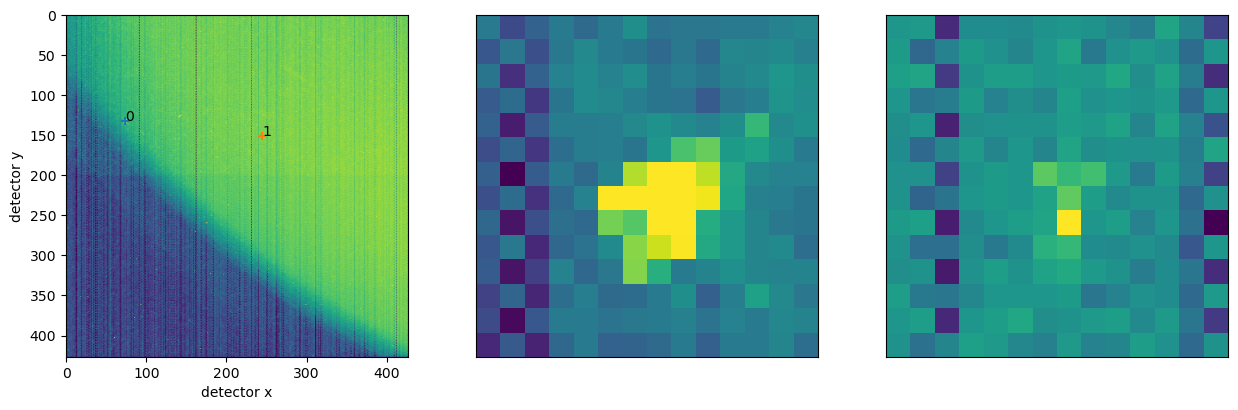

In [77]:
def check_images(dataframe, filename):

    samples = dataframe[dataframe["image"] == filename]
    fig, axis = plt.subplots(1, 1 + len(samples), figsize = (5 + len(samples)*5, 5))
    img = cv2.imread(img_raw, cv2.IMREAD_GRAYSCALE)
    lim = 7

    for i in range(len(samples)+1):
        if i == 0:
            axis[i].imshow(img)
            axis[i].set_xlabel("detector x"), axis[i].set_ylabel("detector y")
            for j in range(len(samples)):
                x = int(samples["x_center"].iloc[j])
                y = int(samples["y_center"].iloc[j])
                axis[i].scatter(x, y, marker = "+")
                axis[i].text(x, y, str(j))
        else:
            x = int(samples["x_center"].iloc[i-1])
            y = int(samples["y_center"].iloc[i-1])
            img_new = img[y-lim:y+lim, x-lim:x+lim]
            axis[i].imshow(img_new)
            axis[i].set_xticks([]), axis[i].set_yticks([])
    img = cv2.imread(img_raw, cv2.IMREAD_GRAYSCALE)
    axis[0].imshow(img)

file = img_raw = df.sample(1)["image"].iloc[0]
check_images(df,file)

In [71]:
img.shape

(427, 427)